In [1]:
import roboticstoolbox as rtb
import numpy as np
import math
import matplotlib.pyplot as plt
#import swift

In [2]:
# trajectory
# x: axis x pos
# alpha:  rotation around the x-axis

def x_ref(x0, t):
    return x0 + 0.2 * math.sin(t)

def alpha_ref(alpha0, t):
    return alpha0 + 3.14 * math.sin(t)

In [3]:
# a 7-axis collaborative Franka Emika Panda robot
robot = rtb.models.Panda()
robot.q = robot.qr  # ready position

In [4]:
# Initial Forward Kinematics
fk0 = robot.fkine(robot.q)
x0, y0, z0 = fk0.t  # starting center of spiral

In [11]:
# Spiral parameters
r_min = 0.02
r_max = 0.1
omega = 2*np.pi
vz = 0.05

In [12]:
# simulation parameters
t_sim = 5
dt = 0.01
time_vec = np.arange(0, t_sim, dt)

trajectory = []

In [13]:
# PD gains
Kp = 5.0
Kd = 0.1

In [14]:
# --- Initialize previous error for derivative ---
prev_x_error = np.zeros(6)

# --- main loop ---
for t in time_vec:
    # Spiral reference
    r = r_min + (r_max - r_min)*(t/t_sim)
    xd_pos = np.array([
        x0 + r*np.cos(omega*t),
        y0 + r*np.sin(omega*t),
        z0 + vz*t
    ])
    
    # Current FK
    fk = robot.fkine(robot.q)
    x, y, z = fk.t
    alpha, beta, gamma = fk.eul()
    
    # Task-space error (position only)
    x_error = np.array([
        xd_pos[0]-x,
        xd_pos[1]-y,
        xd_pos[2]-z,
        0, 0, 0
    ])
    
    # PD controller (velocity in task space)
    v_ee = Kp*x_error + Kd*((x_error - prev_x_error)/dt)
    prev_x_error = x_error.copy()
    
    # Map to joint velocities
    J = robot.jacob0(robot.q)
    robot.qd = np.linalg.pinv(J) @ v_ee
    
    # Step joints
    robot.q = robot.q + robot.qd * dt
    
    # Store end-effector position
    trajectory.append([x, y, z])

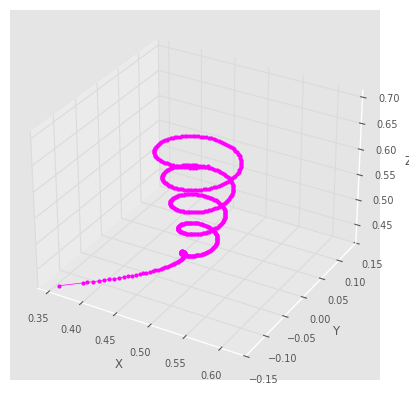

In [15]:
# --- Plot trajectory ---
trajectory = np.array(trajectory)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], 'magenta', marker='o', markersize=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(x0-0.15, x0+0.15)
ax.set_ylim(y0-0.15, y0+0.15)
ax.set_zlim(z0, z0+vz*t_sim+0.05)
plt.show()